In [1]:
from IPython.core.events import EventManager
from IPython import get_ipython
import time

global_start_time = None

def start_timer(event):
    global global_start_time
    global_start_time = time.time()

def stop_timer(event):
    global global_start_time
    if global_start_time:
        duration = time.time() - global_start_time
        print(f"Cell execution time: {duration:.3f} seconds")
        global_start_time = None

ip = get_ipython()
ip.events.register('pre_run_cell', start_timer)
ip.events.register('post_run_cell', stop_timer)

In [2]:
from skimage import io 
import pandas as pd 
import matplotlib.pyplot as plt
import gc
import numpy as np
from glob import glob 
import cv2
import matplotlib.colors as mcolors
from scipy.sparse import lil_matrix

Cell execution time: 1.221 seconds


In [3]:
red_denom = 2**13
blue_denom = 2**14
green_denom = 2**12
yellow_denom = 2**13

blue_adjust = 1.2
yellow_adjust = 1.1 
red_adjust = 1.8
green_adjust = 1.8

gamma = 1.4

Cell execution time: 0.000 seconds


In [4]:
red_mat = io.imread("../channel/PTB21.1_Red.tiff")
rawR = np.clip(red_mat /     red_denom,    0, 1)
imgR_norm = np.power(rawR, gamma) * red_adjust
imgR_final = np.clip(imgR_norm,                0, 1)
del red_mat
del rawR
del imgR_norm
gc.collect()

266

Cell execution time: 163.472 seconds


In [5]:
yellow_mat = io.imread("../channel/PTB21.1_Blue.tiff")
rawY = np.clip(yellow_mat / yellow_denom,    0, 1)
del yellow_mat

Cell execution time: 49.326 seconds


In [6]:
imgY_norm = np.power(rawY, gamma) * yellow_adjust
del rawY
gc.collect()

266

Cell execution time: 56.570 seconds


In [7]:
green_mat = io.imread("../channel/PTB21.1_Yellow.tiff") 

Cell execution time: 21.045 seconds


In [8]:
rawG = np.clip(green_mat /   green_denom,    0, 1)
imgG_norm = np.power(rawG, gamma) * green_adjust

del green_mat
del rawG
gc.collect()

266

Cell execution time: 108.699 seconds


In [9]:
imgG_final = np.clip(imgG_norm + imgY_norm,    0, 1)
del imgG_norm
gc.collect()

0

Cell execution time: 96.681 seconds


In [10]:
blue_mat = io.imread("../channel/PTB21.1_Green.tiff")

Cell execution time: 18.295 seconds


In [11]:
rawB = np.clip(blue_mat /    blue_denom,    0, 1)
imgB_norm = np.power(rawB, gamma) * blue_adjust
del blue_mat
del rawB
gc.collect()

266

Cell execution time: 120.978 seconds


In [12]:
imgB_final = np.clip(imgB_norm + imgY_norm,    0, 1)
del imgB_norm
del imgY_norm
gc.collect()

0

Cell execution time: 120.030 seconds


In [13]:
# full composite scan, requires lot of memory 
img = np.stack((imgR_final,imgG_final, imgB_final), -1)

Cell execution time: 310.880 seconds


In [14]:
del imgR_final
del imgG_final
del imgB_final

Cell execution time: 3.595 seconds


In [15]:
gc.collect()

0

Cell execution time: 0.179 seconds


In [16]:
df = pd.read_excel("../data/geomx_211.xlsx",sheet_name="SegmentProperties")
df = df.loc[df["SlideName"]=="B172914-2"]
df = df[["ROILabel","ROICoordinateX","ROICoordinateY","AOISurfaceArea"]]

Cell execution time: 0.545 seconds


In [17]:
bb_fns = glob("../bb_mask/PTB211*")

Cell execution time: 0.002 seconds


In [18]:
img_path = "../bb_annot/PTB211_1.png"
tmp_img=plt.imread(img_path)
xw = np.floor(tmp_img.shape[1]/2).astype(int)

Cell execution time: 0.169 seconds


In [19]:
# big font and bounding box matrix 
mask = lil_matrix(img.shape[:2], dtype=np.uint8)
# small font and bounding box matrix 
mini_mask = lil_matrix(img.shape[:2], dtype=np.uint8)

Cell execution time: 0.139 seconds


In [20]:
# first estimate of text placement around bounding box 
font_dict = {i:(np.floor(xw/4).astype(int)-151,np.floor(xw/2).astype(int)) for i in df.ROILabel.values}

# second estimate of text placement 
for bbf in bb_fns:
    roi=bbf.split("_")[-1].split(".npy")[0]
    roi=int(roi)
    if roi not in df["ROILabel"].values:
        continue

    # bounding box 
    bb_mat = np.load(bbf)

    # resized bounding box used for estimates in text placement along y-axis 
    bbr_mat = cv2.resize(bb_mat.astype(float), (xw*2,xw*2), interpolation=cv2.INTER_LANCZOS4)

    font_dict[roi] = (font_dict[roi][0],np.where(bbr_mat.sum(1)>0)[0][0]-100)
    if roi == 8:
        font_dict[roi] = (font_dict[roi][0],np.where(bbr_mat.sum(1)>0)[0][-1]+1000)
    if roi == 2:
        font_dict[roi] = (font_dict[roi][0]-300,font_dict[roi][1]+100)
    if roi == 3:
        font_dict[roi] = (font_dict[roi][0]+600,font_dict[roi][1]+100)
    if roi == 6:
        font_dict[roi] = (1200,np.floor(np.mean(np.where(bbr_mat.sum(0)>0)[0])+600).astype(int))

Cell execution time: 0.770 seconds


In [21]:
# smaller version of font dict for mini text placement 
font_dict_mini = {i:(np.floor(xw/4).astype(int)-151,np.floor(xw/2).astype(int)) for i in df.ROILabel.values}

for bbf in bb_fns:
    roi=bbf.split("_")[-1].split(".npy")[0]
    roi=int(roi)
    if roi not in df["ROILabel"].values:
        continue

    # bounding box 
    bb_mat = np.load(bbf)
    bbr_mat = cv2.resize(bb_mat.astype(float), (xw*2,xw*2), interpolation=cv2.INTER_LANCZOS4)
    bbr_mat[bbr_mat>0.33] = 2
    
    font_dict_mini[roi] = (font_dict_mini[roi][0],np.where(bbr_mat.sum(1)>0)[0][0]-100)
    if roi == 8:
        font_dict_mini[roi] = (font_dict_mini[roi][0],np.where(bbr_mat.sum(1)>0)[0][-1]+200)
    if roi == 6:
        font_dict_mini[roi] = (750,np.floor(np.mean(np.where(bbr_mat.sum(0)>0)[0])+100).astype(int))

Cell execution time: 0.680 seconds


In [22]:
# iterate through each file, place the bounding box and text 
for bbf in bb_fns:
    # getting ROI and loading bounding box 
    roi=bbf.split("_")[-1].split(".npy")[0]
    roi=int(roi)
    if roi not in df["ROILabel"].values:
        continue

    bb_mat = np.load(bbf)

    ry,rx=df.loc[df["ROILabel"]==roi,["ROICoordinateX","ROICoordinateY"]].values[0]
    ry=np.int64(ry)
    rx=np.int64(rx)

    # bounding box has its middle filled in using contours 
    bbr_mat = cv2.resize(bb_mat.astype(float), (xw*2,xw*2), interpolation=cv2.INTER_LANCZOS4)
    
    bbr_bin = (bbr_mat > 0).astype(np.uint8)          
    contours, _ = cv2.findContours(
        bbr_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    fill_color = 2                                   
    cv2.drawContours(bbr_mat, contours, -1, fill_color, thickness=-1)
    
    bbr_mat[bbr_mat>0.33] = roi

    region_mask = mask[(rx-xw):(rx+xw),(ry-xw):(ry+xw)].toarray()
    
    # we do not want to lose surrounding annotations from past spots 
    max_mat = np.maximum(region_mask, bbr_mat)

    
    # padded space placing text (at current font scale extends beyond xw) 
    pad = 800
    padded_mat = cv2.copyMakeBorder(
        max_mat.astype(np.uint8),
        pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

    text_mask = np.zeros_like(padded_mat)
    font = cv2.FONT_HERSHEY_COMPLEX
    font_scale = 24
    thickness = 48
    position = (xw-font_dict[roi][0]+400, font_dict[roi][1]+500)  
    white_color = (1)  
    cv2.putText(text_mask, str(roi).zfill(2), position, font, font_scale, white_color, thickness)

    
    padded_mat[text_mask > 0] = 100 + roi 

    r0 = rx - xw - pad
    r1 = rx + xw + pad
    c0 = ry - xw - pad
    c1 = ry + xw + pad

    sub_mask = mask[r0:r1, c0:c1].copy()
    sub_mask = sub_mask.toarray()

    # mask has encoding for each spot bounding box (roi int) and text (roi + 100 int) 
    mask[r0:r1, c0:c1] = np.maximum(sub_mask, padded_mat)

    # place smaller font on mini version 
    region_mask = mini_mask[(rx-xw):(rx+xw),(ry-xw):(ry+xw)].toarray()
    max_mat = np.maximum(region_mask, bbr_mat)
    text_mask = np.zeros_like(max_mat)
    font_scale = 4
    thickness = 12
    position = (xw-font_dict_mini[roi][0]+50, font_dict_mini[roi][1]) 
    cv2.putText(text_mask, str(roi).zfill(2), position, font, font_scale, white_color, thickness)
    max_mat[text_mask > 0] = 100 + roi 
    mini_mask[(rx-xw):(rx+xw),(ry-xw):(ry+xw)] = max_mat

Cell execution time: 13.236 seconds


In [23]:
# simplify mask codes to just distinguish text and bounding boxes 
csr_mask = mask.tocsr()
d = csr_mask.data
d[(d > 1) & (d < 100)] = 1
d[d >= 100] = 2
mask = csr_mask.toarray()

# simplify mask codes to just distinguish text and bounding boxes 
csr_mini_mask = mini_mask.tocsr()
d = csr_mini_mask.data
d[(d > 1) & (d < 100)] = 1
d[d >= 100] = 2
mini_mask = csr_mini_mask.toarray()

Cell execution time: 0.448 seconds


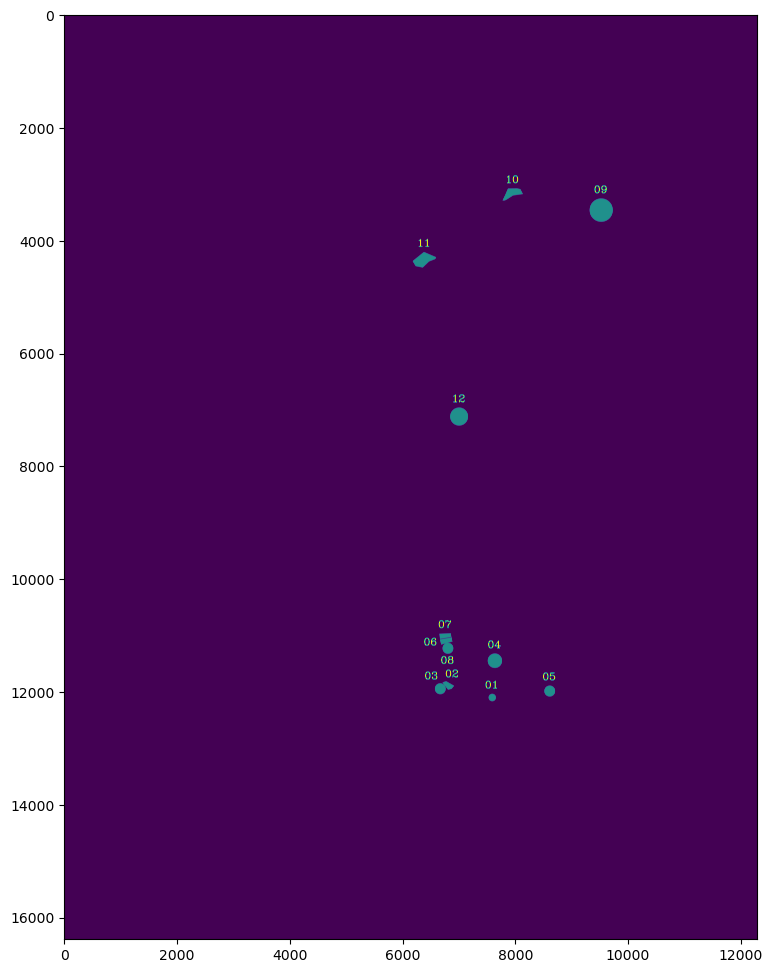

Cell execution time: 9.177 seconds


In [24]:
# downsize mask and plot to see if placement is adequate 
mask_small = cv2.resize(mask, (mask.shape[1]//4, mask.shape[0]//4),
                         interpolation=cv2.INTER_NEAREST)

mini_mask_small = cv2.resize(mini_mask, (mini_mask.shape[1]//4, mini_mask.shape[0]//4),
                         interpolation=cv2.INTER_NEAREST)

fig,ax=plt.subplots(figsize=(12,12))
plt.imshow(mask_small)

In [25]:
# downsize image 
img_small  = cv2.resize(img,   (img.shape[1]//4, img.shape[0]//4),
                         interpolation=cv2.INTER_AREA)
img_small = cv2.cvtColor((img_small * 255).clip(0, 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

Cell execution time: 56.635 seconds


In [26]:
# save image using mask overlay 
mask_small = (mask_small > 0).astype(np.uint8)


overlay = np.zeros_like(img_small, dtype=np.uint8)
overlay[mask_small == 1] = (255, 255, 255)  

alpha = 0.5                                 
blended = cv2.addWeighted(img_small, 1.0,
                          overlay,   alpha, 0)

cv2.imwrite("../plots/ptb211_label.png", blended)

True

Cell execution time: 4.032 seconds


In [27]:
# save image using mask overlay 
mini_mask_small = (mini_mask_small > 0).astype(np.uint8)


overlay = np.zeros_like(img_small, dtype=np.uint8)
overlay[mini_mask_small == 1] = (255, 255, 255)  

alpha = 0.5                                 
blended = cv2.addWeighted(img_small, 1.0,
                          overlay,   alpha, 0)

cv2.imwrite("../plots/ptb211_mini_label.png", blended)

True

Cell execution time: 3.996 seconds
